<h1>DNN RUN TEST

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import sklearn

#建立與 MySQL 的連結
class mysql_engine():
 def __init__(self,db):
  self.user='root'
  self.passwd='ian1991'
  self.host='localhost'
  self.port = '3306'
  self.db_name= db
  self.engine = create_engine('mysql+pymysql://{0}:{1}@{2}:{3}/{4}?charset=utf8'.format(self.user,self.passwd,self.host,self.port,self.db_name))

def get_data(sql,db):
 pg_enine = mysql_engine(db)
 try:
  with pg_enine.engine.connect() as con, con.begin():
   df = pd.read_sql(sql,con) # 獲取資料
  con.close()
 except:
  df = None
 return df

In [2]:
company_factor = get_data("""SELECT 
                            operating_gross_rate, 
                            current_rate, 
                            quick_rate,  
                            debt_rate,  
                            receivables_turnover_rate, 
                            cash_reinvest_rate,
                            avg_director_rate, 
                            avg_director_pledge_rate, 
                            foreign_rate_bys, 
                            over1000_rate_bys, 
                            under400_rate_bys, 
                            avg_board_bys
                            FROM tfb103d_project.datamining_alldata_afetl
                            WHERE stock_report_date < '20212';""",'tfb103d_project')
company_factor

,operating_gross_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys
0,38.03,154.53,103.70,18.22,3.31,1.74,26.60,0.00,4.40,62.23,33.99,8.73
1,40.93,166.92,110.41,16.86,4.35,1.34,26.60,0.00,4.40,62.35,34.08,8.86
2,37.03,171.94,109.89,16.38,0.99,1.51,26.60,0.00,4.37,62.53,33.68,8.90
3,32.10,174.72,114.79,16.63,2.00,2.17,26.60,0.00,4.30,62.34,33.51,9.01
4,28.78,170.04,116.92,17.45,3.10,4.32,26.60,0.00,4.30,62.33,33.44,9.11
...,...,...,...,...,...,...,...,...,...,...,...,...
1634,30.43,326.95,199.20,25.75,1.99,-0.03,17.70,12.77,56.57,45.83,38.01,10.07
1635,24.76,299.48,181.73,27.74,4.28,6.49,17.70,12.73,51.13,41.64,44.76,7.51
1636,22.61,363.99,240.63,23.66,6.20,5.25,18.23,17.90,45.53,37.24,51.68,6.58
1637,23.05,317.33,230.20,26.09,8.12,11.28,18.40,17.80,47.07,36.67,51.03,6.80


In [3]:
Roe_rul = get_data("""SELECT roe_rate
                      FROM tfb103d_project.datamining_alldata_afetl
                      WHERE stock_report_date > '20183';""",'tfb103d_project')
Roe_rul

,roe_rate
0,0.42
1,-0.20
2,0.85
3,0.17
4,-0.80
...,...
1634,4.01
1635,6.07
1636,11.76
1637,4.71


In [6]:
#缺值檢視
print(company_factor.isnull().sum())
print("-----------------------------")
print(Roe_rul.isnull().sum())

operating_gross_rate         0
current_rate                 0
quick_rate                   0
debt_rate                    0
receivables_turnover_rate    0
cash_reinvest_rate           0
avg_director_rate            0
avg_director_pledge_rate     0
foreign_rate_bys             0
over1000_rate_bys            0
under400_rate_bys            0
avg_board_bys                0
dtype: int64
-----------------------------
roe_rate    0
dtype: int64


In [8]:
# 將數值轉為 1,0 編碼，作為模型的預測目標(應變數)
def encoding(r,th):
    if r >= th:
        return 1
    else:
        return 0
    
#定義股東權益報酬率 >平均者為表現良好
m = Roe_rul['roe_rate'].mean()
Roe_rul['roe_rate1'] = Roe_rul.apply(lambda r : encoding(r['roe_rate'],m), axis = 1)
Roe_rul

,roe_rate,roe_rate1
0,0.42,0
1,-0.20,0
2,0.85,0
3,0.17,0
4,-0.80,0
...,...,...
1634,4.01,1
1635,6.07,1
1636,11.76,1
1637,4.71,1


In [10]:
X = company_factor

y = Roe_rul['roe_rate1']

print("x.shape: " ,X.shape)
print("y.shape: " ,y.shape)
print('y.sum():',y.sum())

x.shape:  (1639, 12)
y.shape:  (1639,)
y.sum(): 884


In [11]:
# 輸入數據調成標準值以免各特徵影響不同

def mean_norm(df_input):
    return df_input.apply(lambda x: ((x-df_input.mean())/ df_input.std()))

X_scaled = pd.DataFrame()
a, b = X.shape

for i in range(b):
    x_new = mean_norm(X[X.columns[i]])
    X_scaled.insert(i,X.columns[i],x_new)
    
X_scaled

,operating_gross_rate,current_rate,quick_rate,debt_rate,receivables_turnover_rate,cash_reinvest_rate,avg_director_rate,avg_director_pledge_rate,foreign_rate_bys,over1000_rate_bys,under400_rate_bys,avg_board_bys
0,0.310530,-0.553189,-0.513366,-0.818028,-0.161824,-0.205327,0.434003,-0.402937,-0.641917,0.840080,-0.635222,-0.310411
1,0.420361,-0.520781,-0.494960,-0.898471,-0.064074,-0.239816,0.434003,-0.402937,-0.641917,0.845653,-0.630684,-0.301024
2,0.272657,-0.507650,-0.496387,-0.926863,-0.379883,-0.225158,0.434003,-0.402937,-0.643402,0.854013,-0.650854,-0.298135
3,0.085944,-0.500379,-0.482945,-0.912075,-0.284953,-0.168251,0.434003,-0.402937,-0.646868,0.845189,-0.659426,-0.290191
4,-0.039793,-0.512620,-0.477102,-0.863573,-0.181562,0.017126,0.434003,-0.402937,-0.646868,0.844724,-0.662956,-0.282970
...,...,...,...,...,...,...,...,...,...,...,...,...
1634,0.022697,-0.102197,-0.251399,-0.372635,-0.285892,-0.357940,-0.083665,0.699086,1.941256,0.078366,-0.432514,-0.213645
1635,-0.192042,-0.174049,-0.299321,-0.254929,-0.070653,0.204228,-0.083665,0.695634,1.671897,-0.116242,-0.092144,-0.398512
1636,-0.273468,-0.005312,-0.137752,-0.496257,0.109809,0.097313,-0.052838,1.141794,1.394616,-0.320605,0.256798,-0.465671
1637,-0.256804,-0.127359,-0.166362,-0.352525,0.290272,0.617232,-0.042950,1.133164,1.470868,-0.347079,0.224021,-0.449784


In [16]:
#分割資料為 測試集 與 訓練集
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)
N, D = X_train.shape
print ("N:", N, "D:", D)

N: 1311 D: 12


In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
print(tf.__version__)

2.6.0


In [18]:
test_list = [2**i for i in range(11) ]
test_list

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

In [19]:
columns1 = ['layers','Train_loss','Train_accuracy','Test_loss','Test_accuracy']
columns2 = ['layers1','layers2','Train_loss','Train_accuracy','Test_loss','Test_accuracy']

<h2>單層神經網路

In [ ]:
result = []
for i in test_list:
    r = 0 
    print(i,"is start~")
    while r < 10:
        # 建立TF模型 for 淨利
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(D,)),
                tf.keras.layers.Dense(i, activation='relu'),
        #          tf.keras.layers.Dropout(0.2),
    #              tf.keras.layers.Dense(j, activation='relu'),
        #          tf.keras.layers.Dropout(0.2),
                 tf.keras.layers.Dense(1, activation='sigmoid')
                 ])

        #編譯模型
        model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

        r1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

        # 評估模型 - evaluate() returns loss and accuracy
        tmp = [i]
        tmp.extend(model.evaluate(X_train, y_train))
        tmp.extend(model.evaluate(X_test, y_test))
        result.append(tmp)
        r +=1
    print(i,"finish!")
df = pd.DataFrame(result, columns=columns1)
df.to_csv("single_layers.csv",index = False)

In [ ]:
result2 = []
for i in test_list:
    for j in test_list:
        t = 0 
        while t < 10:
            # 建立TF模型 for 淨利
            model2 = tf.keras.models.Sequential([
              tf.keras.layers.Input(shape=(D,)),
              tf.keras.layers.Dense(i, activation='relu'),
    #           tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(j, activation='relu'),
    #           tf.keras.layers.Dropout(0.2),
              tf.keras.layers.Dense(1, activation='sigmoid')
              ])

            #編譯模型
            model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

            r2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
            # 評估模型 - evaluate() returns loss and accuracy
            tmp = [i,j]
            tmp.extend(model2.evaluate(X_train, y_train))
            tmp.extend(model2.evaluate(X_test, y_test))
            result2.append(tmp)
            t +=1
df2 = pd.DataFrame(result2, columns=columns2)
df2.to_csv("double_layers.csv",index = False)

In [22]:
df = pd.read_csv("single_layers.csv")
df.head(100)

,layers,Train_loss,Train_accuracy,Test_loss,Test_accuracy
0,1,0.566345,0.726163,0.592070,0.698171
1,1,0.564346,0.731503,0.595955,0.695122
2,1,0.564827,0.726926,0.585489,0.707317
3,1,0.546031,0.745233,0.565075,0.704268
4,1,0.530524,0.749047,0.559765,0.707317
...,...,...,...,...,...
95,512,0.298337,0.881770,0.486301,0.771341
96,512,0.305818,0.874905,0.480307,0.792683
97,512,0.303054,0.873379,0.458929,0.792683
98,512,0.304823,0.877193,0.494235,0.783537


# 單層神經網路測試

In [25]:
df_avg = df.groupby(['layers']).mean()
df_std = df.groupby(['layers']).std()
df_avg
df_avg.to_csv("single_layers_avg.csv",index = True)
df_std
df_std.to_csv("single_layers_std.csv",index = True)

In [22]:
df = pd.read_csv("single_layers.csv")
df.head(100)

,layers,Train_loss,Train_accuracy,Test_loss,Test_accuracy
0,1,0.566345,0.726163,0.592070,0.698171
1,1,0.564346,0.731503,0.595955,0.695122
2,1,0.564827,0.726926,0.585489,0.707317
3,1,0.546031,0.745233,0.565075,0.704268
4,1,0.530524,0.749047,0.559765,0.707317
...,...,...,...,...,...
95,512,0.298337,0.881770,0.486301,0.771341
96,512,0.305818,0.874905,0.480307,0.792683
97,512,0.303054,0.873379,0.458929,0.792683
98,512,0.304823,0.877193,0.494235,0.783537


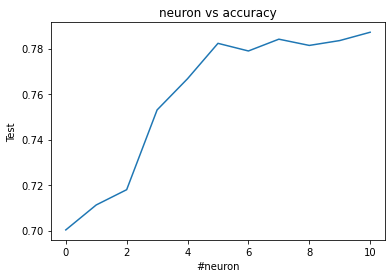

In [34]:
import matplotlib.pyplot as plt
plt.plot([0,1,2,3,4,5,6,7,8,9,10],df_avg['Test_accuracy']) 
# plt.plot([0,1,2,3,4,5,6,7,8,9,10],df_avg['Test_loss']) 
plt.xlabel('#neuron') 
plt.ylabel('Test') 
plt.title('neuron vs accuracy')
plt.savefig(f'./results/neuron_vs_accuracy.png')
plt.show()

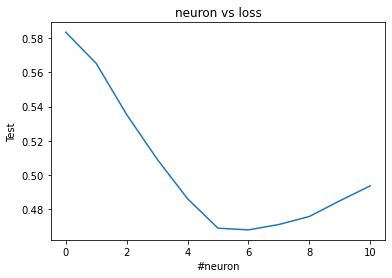

In [35]:
# plt.plot([0,1,2,3,4,5,6,7,8,9,10],df_avg['Test_accuracy']) 
plt.plot([0,1,2,3,4,5,6,7,8,9,10],df_avg['Test_loss']) 
plt.xlabel('#neuron') 
plt.ylabel('Test') 
plt.title('neuron vs loss')
plt.savefig(f'./results/neuron_vs_loss.png')
plt.show()

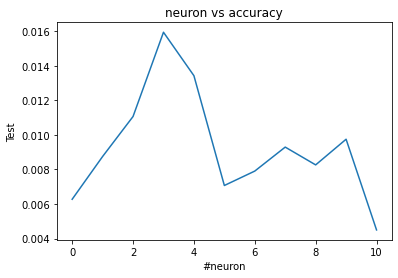

In [37]:
plt.plot([0,1,2,3,4,5,6,7,8,9,10],df_std['Test_accuracy']) 
# plt.plot([0,1,2,3,4,5,6,7,8,9,10],df_std['Test_loss']) 
plt.xlabel('#neuron') 
plt.ylabel('Test') 
plt.title('neuron vs accuracy')
plt.savefig(f'./results/neuron_vs_accuracy_std.png')
plt.show()

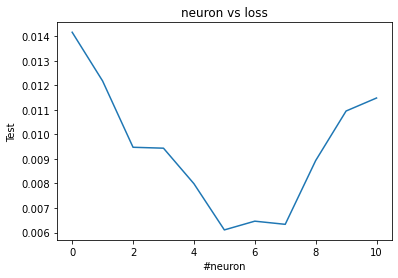

In [36]:
# plt.plot([0,1,2,3,4,5,6,7,8,9,10],df_std['Test_accuracy']) 
plt.plot([0,1,2,3,4,5,6,7,8,9,10],df_std['Test_loss']) 
plt.xlabel('#neuron') 
plt.ylabel('Test') 
plt.title('neuron vs loss')
plt.savefig(f'./results/neuron_vs_loss_std.png')
plt.show()

# 雙層神經網路測試

In [75]:
ddf = pd.read_csv("double_layers.csv")
ddf.head(100)

,layers1,layers2,Train_loss,Train_accuracy,Test_loss,Test_accuracy
0,1,1,0.690408,0.536995,0.688673,0.548781
1,1,1,0.556842,0.723875,0.575478,0.710366
2,1,1,0.563874,0.729977,0.591502,0.692073
3,1,1,0.565537,0.727689,0.594875,0.692073
4,1,1,0.690408,0.536995,0.688684,0.548781
...,...,...,...,...,...,...
95,1,512,0.531106,0.747521,0.568766,0.689024
96,1,512,0.551653,0.729977,0.580236,0.704268
97,1,512,0.537186,0.739893,0.577438,0.713415
98,1,512,0.545684,0.732265,0.568599,0.713415


In [47]:
ddf_avg = ddf.groupby(['layers1','layers2']).mean()
ddf_std = ddf.groupby(['layers1','layers2']).std()
ddf_avg
ddf_avg.to_csv("double_layers_avg.csv",index = True)
ddf_std
ddf_std.to_csv("double_layers_std.csv",index = True)

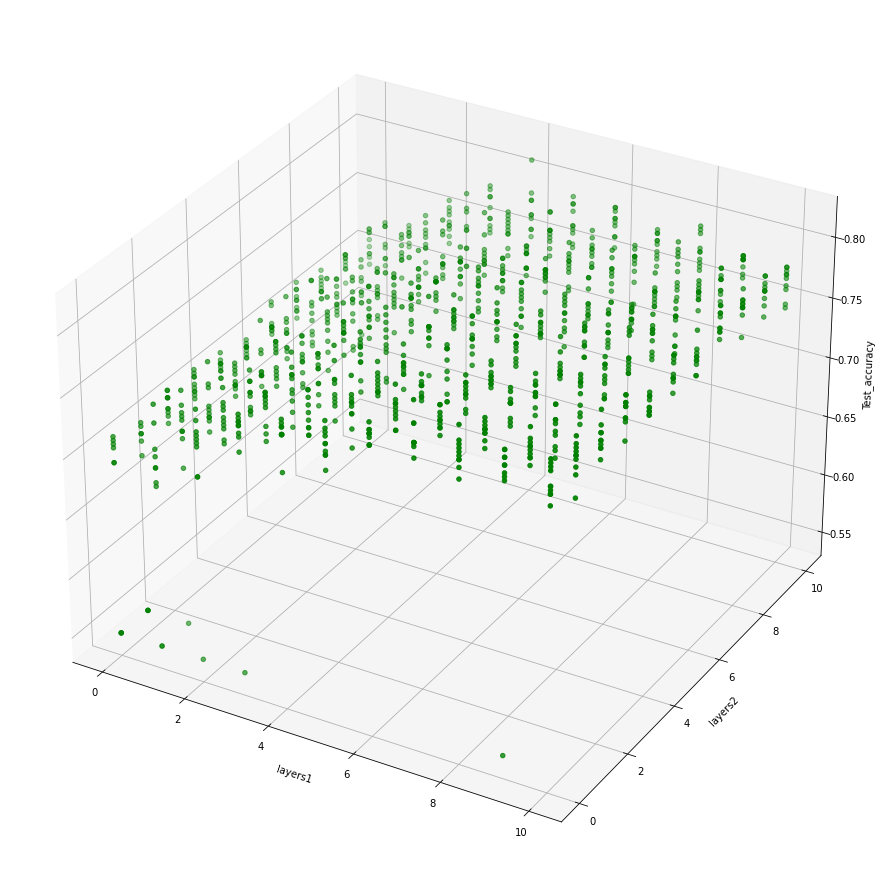

In [81]:
import matplotlib.pyplot as plt
import math
fig = plt.figure(figsize=(16,16))
ax1 = plt.axes(projection = "3d")


ddf['layers1_log'] = ddf.apply(lambda r : math.log(r['layers1'],2) , axis = 1)
ddf['layers2_log'] = ddf.apply(lambda r : math.log(r['layers2'],2) , axis = 1)
X = ddf['layers1_log']
Y = ddf['layers2_log']
Z = ddf['Test_accuracy']


ax1.scatter(X, Y, Z, c='g', marker='o')
ax1.set_xlabel('layers1')
ax1.set_ylabel('layers2')
ax1.set_zlabel('Test_accuracy')
plt.show()

In [78]:
ddf['layers1+2'] = ddf.apply(lambda r : math.log(r['layers1'],2)  +  math.log(r['layers2'],2), axis = 1)
ddf.head(1000)

,layers1,layers2,Train_loss,Train_accuracy,Test_loss,Test_accuracy,layers1+2
0,1,1,0.690408,0.536995,0.688673,0.548781,0.0
1,1,1,0.556842,0.723875,0.575478,0.710366,0.0
2,1,1,0.563874,0.729977,0.591502,0.692073,0.0
3,1,1,0.565537,0.727689,0.594875,0.692073,0.0
4,1,1,0.690408,0.536995,0.688684,0.548781,0.0
...,...,...,...,...,...,...,...
995,512,1,0.340861,0.874905,0.521907,0.774390,9.0
996,512,1,0.302620,0.883295,0.527324,0.783537,9.0
997,512,1,0.298029,0.897025,0.526969,0.771341,9.0
998,512,1,0.352777,0.857361,0.527858,0.783537,9.0


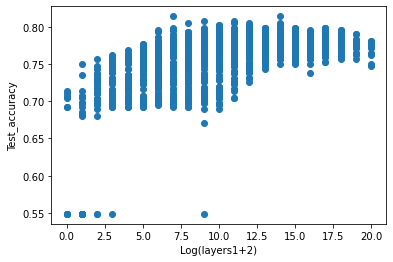

In [79]:
#比較神經元數對準確度的影響
plt.scatter(ddf['layers1+2'],ddf['Test_accuracy']) 
plt.xlabel('Log(layers1+2)') 
plt.ylabel('Test_accuracy') 
# plt.title('Export Value')
plt.show()

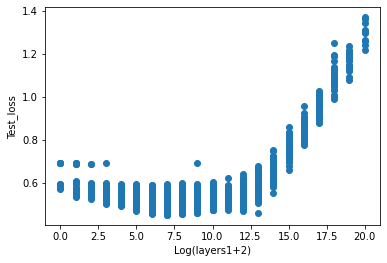

In [80]:
#比較神經元數對準確度的影響
plt.scatter(ddf['layers1+2'],ddf['Test_loss']) 
plt.xlabel('Log(layers1+2)') 
plt.ylabel('Test_loss') 
# plt.title('Export Value')
plt.show()

<h2> DNN 類神經網路建構測試
<h2>1. layers1 的神經元數對於準確度影響比較大
<h2>2. 神經元數越多，準確度提升越高，但有邊際效應；準確度變化越趨向穩定。
<h2>3. 神經元數越多，Loss 越高。

In [ ]:
df_avg.sort_values(by='Test_accuracy',ascending = False).head(50)

In [ ]:
df_avg.sort_values(by='Test_loss',ascending = True).head(50)